In [ ]:
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle competitions download -c cassava-disease

100% 2.30G/2.30G [01:45<00:00, 23.9MB/s]
100% 2.30G/2.30G [01:45<00:00, 23.4MB/s]


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
model = keras.Sequential([
    keras.Input(shape=(64, 64, 3)), # Explicit Input Layer
    layers.Conv2D(32, (3,3), activation="relu", padding="same"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu", padding="same"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation="relu", padding="same"),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5), # Dropout for regularization
    layers.Dense(5, activation="softmax") # Output layer (10 classes)
])


In [ ]:
# Compile the Model
model.compile(
optimizer="adam",
loss="categorical_crossentropy",
metrics=["accuracy"]
)

In [ ]:
# Display Model Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,288,325 (16.36 MB)

 Trainable params: 4,288,325 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# unzip dataset
import zipfile
import glob
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
if not os.path.exists('cassava-disease.zip'):
    print("Error: cassava-disease.zip not found!")
else:
    print("Found cassava-disease.zip")

Found cassava-disease.zip


In [ ]:
print("\nExtracting files...")
with zipfile.ZipFile('cassava-disease.zip', 'r') as zip_ref:
  zip_ref.extractall('dataset')

print("Extracting train.zip...")
with zipfile.ZipFile('dataset/train.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset/train')



Extracting files...
Extracting train.zip...


In [ ]:
def load_preprocess_images(image_path, size=(32,32)):
  img = load_img(image_path, target_size=size)
  img_array = img_to_array(img)
  new_img_array = img_array / 255.0 # normalize pixel values return new_img_array

In [ ]:
# grab images
class_map = {
    'cbb': 0,
    'cmd': 1,
    'cbsd': 2,
    'cgm': 3,
    'healthy': 4
}

train_directory = 'dataset/train/train'
img_paths = glob.glob(os.path.join(train_directory, '*.jpg'))

# list to store images and labels
X = []
y = []

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
BATCH_SIZE = 32

def setup_data_generators(IMG_HEIGHT, IMG_WIDTH):
    # Create training ImageDataGenerator with augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,  # Normalize pixel values
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        validation_split=0.2  # 20% for validation
    )

    # Create training generator
    train_generator = train_datagen.flow_from_directory(
        train_directory,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        shuffle=True,
        classes=list(class_map.keys())
    )

    # Create validation generator
    validation_generator = train_datagen.flow_from_directory(
        train_directory,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        shuffle=True,
        classes=list(class_map.keys())
    )

    return train_generator, validation_generator

In [ ]:
def print_dataset_info():
    class_counts = {}

    # Count images in each class
    for class_name in class_map.keys():
        class_path = os.path.join(train_directory, class_name)
        if os.path.exists(class_path):
            num_images = len([f for f in os.listdir(class_path)
                            if f.endswith(('.jpg', '.jpeg', '.png'))])
            class_counts[class_name] = num_images

    print("\nDataset Information:")
    print("-" * 50)
    total_images = sum(class_counts.values())

    for class_name, count in class_counts.items():
        percentage = (count / total_images) * 100
        print(f"{class_name}: {count} images ({percentage:.2f}%)")

    print("-" * 50)
    print(f"Total images: {total_images}")


In [ ]:
try:
    train_generator, validation_generator = setup_data_generators(64,64)
    print("\nData generators created successfully!")
    print(f"Found {train_generator.samples} training samples")
    print(f"Found {validation_generator.samples} validation samples")

    # Print class indices
    print("\nClass mapping:")
    for class_name, class_idx in train_generator.class_indices.items():
        print(f"{class_name}: {class_idx}")

    # Print detailed dataset information
    print_dataset_info()

except Exception as e:
    print(f"Error setting up data generators: {str(e)}")

Found 4527 images belonging to 5 classes.
Found 1129 images belonging to 5 classes.

Data generators created successfully!
Found 4527 training samples
Found 1129 validation samples

Class mapping:
cbb: 0
cmd: 1
cbsd: 2
cgm: 3
healthy: 4

Dataset Information:
--------------------------------------------------
cbb: 466 images (8.24%)
cmd: 2658 images (46.99%)
cbsd: 1443 images (25.51%)
cgm: 773 images (13.67%)
healthy: 316 images (5.59%)
--------------------------------------------------
Total images: 5656


In [ ]:
train = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=5),
        keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3)]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 36s 215ms/step - accuracy: 0.4291 - loss: 1.4319 - val_accuracy: 0.5013 - val_loss: 1.2420 - learning_rate: 0.0010
Epoch 2/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 26s 183ms/step - accuracy: 0.5252 - loss: 1.2787 - val_accuracy: 0.5040 - val_loss: 1.2367 - learning_rate: 0.0010
Epoch 3/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 26s 183ms/step - accuracy: 0.5571 - loss: 1.2121 - val_accuracy: 0.5988 - val_loss: 1.1058 - learning_rate: 0.0010
Epoch 4/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 26s 183ms/step - accuracy: 0.5724 - loss: 1.1869 - val_accuracy: 0.6094 - val_loss: 1.0934 - learning_rate: 0.0010
Epoch 5/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 26s 183ms/step - accuracy: 0.5916 - loss: 1.1623 - val_accuracy: 0.5793 - val_loss: 1.1306 - learning_rate: 0.0010
Epoch 6/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 26s 182ms/step - accuracy: 0.5919 - loss: 1.1401 - val_accuracy: 0.6351 - val_loss: 1.0241 - learning_rate: 0.0010
Epoch 7/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 26s 182ms/step - accuracy: 0.6

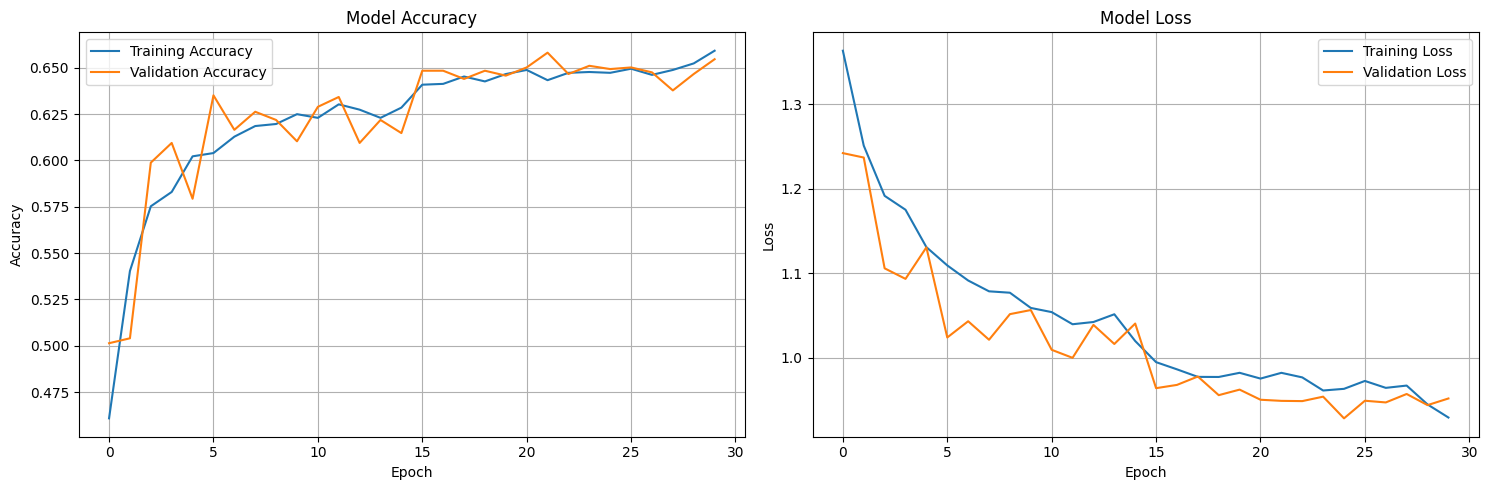

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(train):
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training & validation accuracy
    ax1.plot(train.history['accuracy'], label='Training Accuracy')
    ax1.plot(train.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plot training & validation loss
    ax2.plot(train.history['loss'], label='Training Loss')
    ax2.plot(train.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(train)

In [ ]:
improved_model = keras.Sequential([
    keras.Input(shape=(128, 128, 3)), # Explicit Input Layer

    layers.Conv2D(64, (3,3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3,3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3,3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),

    layers.Conv2D(256, (3,3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3,3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),

    layers.Conv2D(512, (3,3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),


    layers.Flatten(),
    layers.Dense(1024, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(512, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.5), # Dropout for regularization
    layers.Dense(5, activation="softmax") # Output layer (10 classes)
])

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.0005)

improved_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
try:
    train_generator2, validation_generator2 = setup_data_generators(128,128)
    print("\nData generators created successfully!")
    print(f"Found {train_generator2.samples} training samples")
    print(f"Found {validation_generator2.samples} validation samples")

    # Print class indices
    print("\nClass mapping:")
    for class_name, class_idx in train_generator2.class_indices.items():
        print(f"{class_name}: {class_idx}")

    # Print detailed dataset information
    print_dataset_info()

except Exception as e:
    print(f"Error setting up data generators: {str(e)}")

Found 4527 images belonging to 5 classes.
Found 1129 images belonging to 5 classes.

Data generators created successfully!
Found 4527 training samples
Found 1129 validation samples

Class mapping:
cbb: 0
cmd: 1
cbsd: 2
cgm: 3
healthy: 4

Dataset Information:
--------------------------------------------------
cbb: 466 images (8.24%)
cmd: 2658 images (46.99%)
cbsd: 1443 images (25.51%)
cgm: 773 images (13.67%)
healthy: 316 images (5.59%)
--------------------------------------------------
Total images: 5656


In [ ]:
new_train = improved_model.fit(
    train_generator2,
    validation_data=validation_generator2,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=5),
        keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3)]
)

Epoch 1/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 99s 503ms/step - accuracy: 0.3230 - loss: 2.3223 - val_accuracy: 0.4703 - val_loss: 3.1278 - learning_rate: 5.0000e-04
Epoch 2/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 48s 336ms/step - accuracy: 0.4495 - loss: 1.7471 - val_accuracy: 0.1993 - val_loss: 2.8542 - learning_rate: 5.0000e-04
Epoch 3/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 47s 328ms/step - accuracy: 0.5127 - loss: 1.5089 - val_accuracy: 0.3357 - val_loss: 2.3092 - learning_rate: 5.0000e-04
Epoch 4/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 48s 337ms/step - accuracy: 0.5292 - loss: 1.4163 - val_accuracy: 0.5917 - val_loss: 1.3774 - learning_rate: 5.0000e-04
Epoch 5/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 47s 331ms/step - accuracy: 0.5567 - loss: 1.3024 - val_accuracy: 0.6138 - val_loss: 1.1005 - learning_rate: 5.0000e-04
Epoch 6/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 47s 328ms/step - accuracy: 0.5936 - loss: 1.1748 - val_accuracy: 0.6041 - val_loss: 1.1870 - learning_rate: 5.0000e-04
Epoch 7/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 46s 32

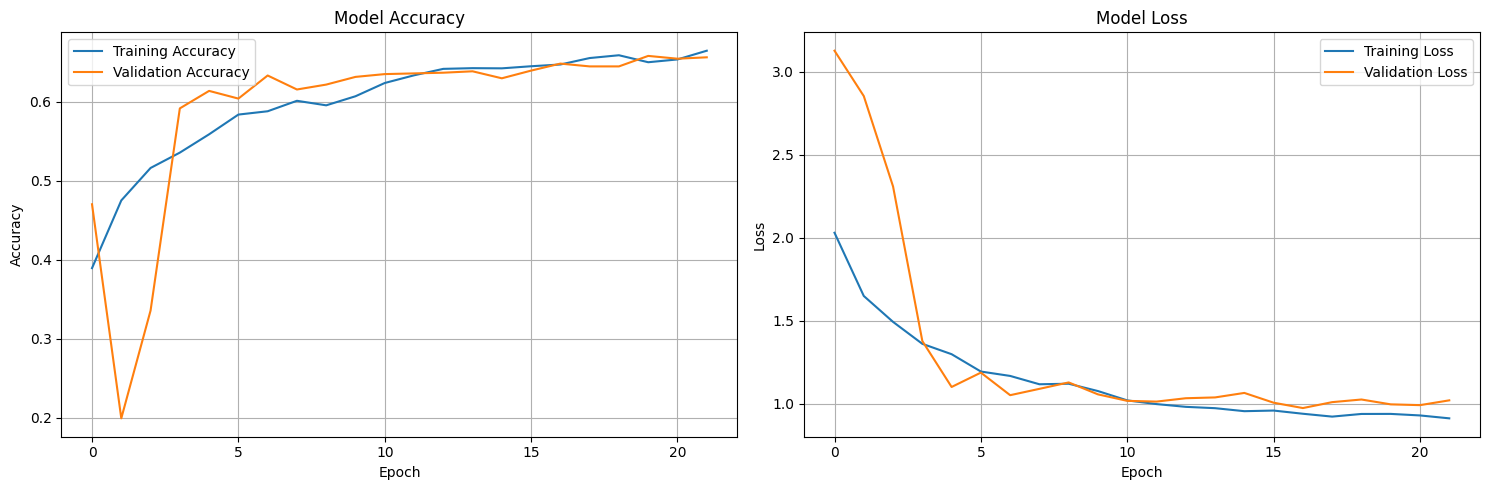

In [ ]:
plot_training_history(new_train)